# 1 Introduction
Here is a brief layout of this report on the Dry Bean Dataset:
- Load data and prepare environment
- Obtain dataset overview with the aggregated table
- Introduce data preprocess approaches used in this report
- Employ the miltilinear regression model on Area: 1) With PCA n=3; 2) With 3 selected features
- Employ classification learners: Find out the top 3 learners
- Optimize the top 1 learner

# 2 Load Data and Prepare Environment

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RepeatedKFold    
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
path_to_file = 'Dry_Bean_Dataset.xlsx'
df = pd.read_excel(path_to_file)
df.head(5)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


# 3 Obtain Aggregated Data Table
In this section, I present an aggregated data table for Area per class showing average, standard deviation, 80th–confidence interval, iqr–interval, count, numbers of outliers with respect to the iqr–interval.

In [3]:
# Group by Class and calculate statistics
grouped = df.groupby('Class')['Area'].agg(['mean', 'std', lambda x: np.percentile(x, 25), 
                                           lambda x: np.percentile(x, 75), 'count'])
# Rename columns
grouped.columns = ['average', 'standard deviation', 'iqr-interval-lower', 'iqr-interval-upper', 'count']
grouped['iqr-interval'] = grouped['iqr-interval-upper'] - grouped['iqr-interval-lower']
# Compute the t-score
confidence_level = 0.8
degrees_of_freedom = len(df) - 1
t_score = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
# Compute margin error
margin_error = t_score *  grouped['standard deviation'] / np.sqrt(grouped['count'])
grouped['80th-lower_bound'] = grouped['average'] - margin_error
grouped['80th-upper_bound'] = grouped['average'] + margin_error

outliers = pd.DataFrame()
for index, row in grouped.iterrows():
    count_outliers = ((df['Class'] == index) & ((df['Area'] < (row['iqr-interval-lower']-1.5*row['iqr-interval']))
                                                | (df['Area'] > (row['iqr-interval-upper']+1.5*row['iqr-interval'])))).sum()
    outliers.loc[index, 'number of outliers (iqr-interval)'] = count_outliers

# Merge with original table
result = pd.merge(grouped, outliers.astype('int'), left_index=True, right_index=True)
result

,average,standard deviation,iqr-interval-lower,iqr-interval-upper,count,iqr-interval,80th-lower_bound,80th-upper_bound,number of outliers (iqr-interval)
Class,,,,,,,,,
BARBUNYA,69804.133132,10265.386454,62931.00,76306.50,1322,13375.50,69442.292993,70165.973271,12
BOMBAY,173485.059387,23327.688116,156711.25,186599.00,522,29887.75,172176.499466,174793.619308,7
CALI,75538.211043,9379.881487,69343.50,81304.75,1630,11961.25,75240.454911,75835.967175,29
DERMASON,32118.710942,4676.129470,28549.25,35581.00,3546,7031.75,32018.070085,32219.351799,0
HOROZ,53648.508817,7341.397869,48909.75,58573.50,1928,9663.75,53434.228435,53862.789200,23
SEKER,39881.299951,4779.877395,36408.00,42700.00,2027,6292.00,39745.234756,40017.365146,37
SIRA,44729.128604,4546.769886,41612.00,47772.00,2636,6160.00,44615.630805,44842.626402,14


# 4 Preprocess Data
In this section, I will introduce methods of data preprocessing used in this report below:
- As indicated by the dataset website, there isn't any missing value, so nothing is done to handle missing values.
- As each features has dramatically different magnitudes, I normalized the data to facilitate the learning process of used models.
- According to the aggregated table above, we can see that each class has a few outliers based on IQR, so I created a function below to remove them.
- When the Class feature is used as a dependent variable for classification learners, I observed that the frequency distribution of different class categories are very uneven, so I used the SMOTE technique to rebalance the dataset for the learners to tarin on.

## 4.1 Function for Removing Outliers

In [4]:
def remove_outliers(df):
    # Calculate the 1.5 IQR range for each class
    grouped = df.groupby('Class')['Area'].agg(['median', lambda x: np.percentile(x, 25), 
                                               lambda x: np.percentile(x, 75)])
    grouped['iqr'] = grouped.iloc[:, 2] - grouped.iloc[:, 1]
    grouped['outlier_min'] = grouped.iloc[:, 1] - 1.5 * grouped['iqr']
    grouped['outlier_max'] = grouped.iloc[:, 2] + 1.5 * grouped['iqr']

    # Create a boolean mask indicating whether each data point is an outlier or not
    is_outlier = df.apply(lambda row: row['Area'] < grouped.loc[row['Class'], 'outlier_min'] or 
                           row['Area'] > grouped.loc[row['Class'], 'outlier_max'], axis=1)

    # Filter the original dataframe to remove the outliers
    return df[~is_outlier]

## 4.2 Rebalance the Dataset
According to the bar chart below, we can see that the dataset is very imbalanced with the class "DERMASON" appearing as many as seven times the class "BOMBAY". Therefore, we use the SMOTE technique to rebalance the dataset when using classification learners for the Class dependent variable. When preprocessing the data, we conduct SMOTE before PCA because PCA operates based on the variance of the features and can potentially remove features that are important for the minority class, especially if the variance in those features is low. 

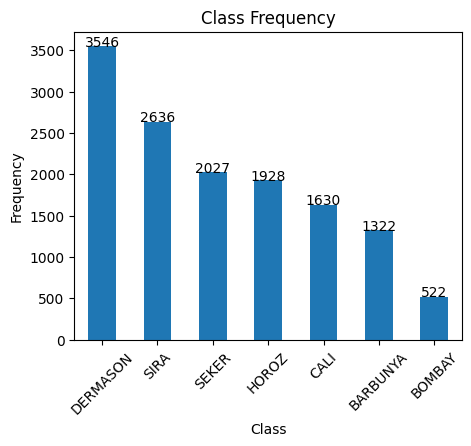

In [5]:
# Plot the class frequency distribution to see if the dataset is balanced in terms of Class
plt.figure(figsize=(5,4))
df['Class'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.xticks(rotation=45)
for i in range(len(df['Class'].value_counts())):
    plt.text(i, df['Class'].value_counts()[i], df['Class'].value_counts()[i], ha='center')
plt.show()

## 4.3 Function for Preprocessing
- All the approaches mentioned above is incorporated in the get_preprocessed_data_regression() and get_preprocessed_data_classification() functions, which manipulatable parameters to control which approaches to use for that particular experiment. 
- While I conducted normalization and outlier elimination for all models, I make SMOTE, PCA and feature selection optional.

In [6]:
def get_preprocessed_data(task, feature_select=['none'], if_smote=True, if_pca=False, n_pca=3):
    df = pd.read_excel(path_to_file)
    df["Class"] = df["Class"].astype('category')
    # Remove outliers per class
    df = remove_outliers(df)
    
    if task == 'classification':
        X = df.drop(columns=["Class"])
        y = df['Class']
    else:
        X = df.drop(columns=["ConvexArea", "Class", 'Area'])
        y = df['Area']
    
    if feature_select != ['none']:
        X = X[feature_select]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=47)
    
    # Normalize the data.
    scaler_model = StandardScaler()
    scaler_model.fit(np.array(X_train))
    X_train = scaler_model.transform(np.array(X_train))
    X_test = scaler_model.transform(np.array(X_test))
    
    # Rebalance the subtraining dataset using SMOTE method.
    if if_smote:
        sm = SMOTE(random_state=47, sampling_strategy='minority', k_neighbors=5)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Conduct PCA with specified n_components.
    if if_pca:
        # Apply PCA transformation based on the subtraining dataset.
        pca = PCA(n_components=n_pca)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# 5 Employ the Multilinear Regression Model for Area
## 5.1 Function for Model Validation
This function accomplishes the following tasks in one setting:
- Preprocess the dataset according to the parameters selected.
- Split the dataset into training and testing sets
- Employ k-fold validation by further splitting the training set into subtraining and subtesting sets
- Generate evaluation results for metrics: 1) k-fold training R^2, testing R^2 and RMSE; 2) testing set R^2 and RMSE 

In [7]:
def model_validation_regression(base_model=LinearRegression(), 
                                cv_splits=5, cv_repeats=1, split_test_size=.4, split_random_state=47,
                                feature_select=['none'], if_pca=True, n_pca=3):
    df = pd.read_excel(path_to_file)
    df['Class'] = df['Class'].astype('category')
    # Remove outliers per class
    df = remove_outliers(df)
    X = df.drop(columns=["ConvexArea", "Class", 'Area'])
    y = df['Area']
    
    if feature_select != ['none']:
        X = X[feature_select]
    
    # Split the data into training and testing datasets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_random_state)
    
    # Initiate k-fold cross-validation.
    cv = RepeatedKFold(n_splits=cv_splits, random_state=47, n_repeats=cv_repeats)
    splitting = cv.split(X=X_train, y=y_train)
    
    RMSEs = []
    train_r2_scores = []
    test_r2_scores = []
    for train_index, test_index in splitting:
        X_subtraining = X_train.iloc[train_index, :]
        X_subtesting = X_train.iloc[test_index, :]
        y_subtraining = y_train.iloc[train_index]
        y_subtesting = y_train.iloc[test_index]

        # Normalize the data.
        scaler_model = StandardScaler()
        scaler_model.fit(np.array(X_subtraining))
        X_subtraining = scaler_model.transform(np.array(X_subtraining))
        X_subtesting = scaler_model.transform(np.array(X_subtesting))

        # Conduct PCA with specified n_components.
        if if_pca:
            # Apply PCA transformation based on the subtraining dataset.
            pca = PCA(n_components=n_pca)
            pca.fit(X_subtraining)
            X_subtraining = pca.transform(X_subtraining)
            X_subtesting = pca.transform(X_subtesting)

        # Train model based on the subtraining dataset.
        base_model.fit(X=X_subtraining, y=y_subtraining)
        
        # Model validation on the substesting dataset.
        y_pred = base_model.predict(X_subtesting)
        
        train_r2_score = base_model.score(X=X_subtraining, y=y_subtraining)
        test_r2_score = base_model.score(X=X_subtesting, y=y_subtesting)
        RMSE = mean_squared_error(y_true=y_subtesting, y_pred=y_pred, squared=False)
        
        RMSEs.append(RMSE)
        train_r2_scores.append(train_r2_score)
        test_r2_scores.append(test_r2_score)
        
    # Evaluate on the testing dataset. 
    # Get the preprocessed data in the same way as defined above
    X_train, X_test, y_train, y_test = get_preprocessed_data('regression', feature_select, False, if_pca, n_pca)
    
    base_model.fit(X=X_train, y=y_train)
    y_pred = base_model.predict(X_test)
    
    test_r2_score = base_model.score(X=X_test, y=y_test)
    RMSE = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    # Print evaluation results
    print(f"""K-Fold Cross-Validation Results:\ntrain_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}""") 
    print(f"""\nPerformance on the Test Dataset:\nR^2: {test_r2_score}\nRMSE: {RMSE}""")
    
    # Draw the distribution of the residuals.
    plt.title('Residual Distribution of the Testing Dataset')
    plt.rcParams["figure.figsize"] = [7, 2]
    plt.rcParams["figure.autolayout"] = True
    sns.kdeplot(x=(y_test - y_pred), fill=True, alpha=0.2);
    sns.histplot(x=(y_test - y_pred), fill=True, alpha=0.2, stat='density');
    sns.kdeplot(x=np.random.normal(scale=np.std((y_test - y_pred)), size=100000), fill=True, alpha=0.2, color='purple');

## 5.2 Multilinear Regression Model + PCA (n_component=3)
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- PCA with n_components=3
- No feature selection

K-Fold Cross-Validation Results:
train_R^2: 0.9378176084180068
test_R^2: 0.9374520713207135
RMSE: 7356.087314185675

Performance on the Test Dataset:
R^2: 0.9367459188006334
RMSE: 7126.306461290082


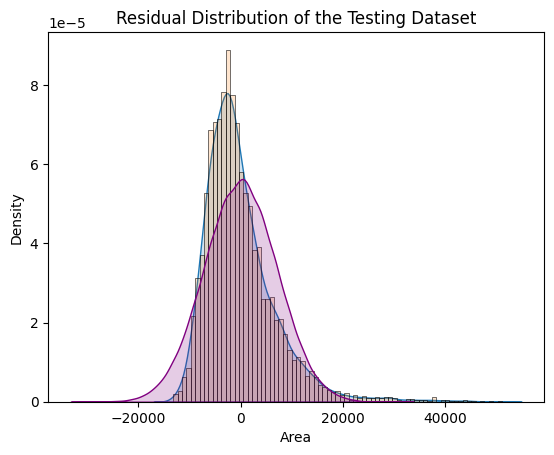

In [8]:
model_validation_regression(base_model=LinearRegression(),
                            cv_splits=5, cv_repeats=1, split_test_size=.4, split_random_state=47,
                            feature_select=['none'], if_pca=True, n_pca=3)

## 5.3 Multilinear Regression Model + 3 selected regressors
According to the correlation matrix, besides the feature ConvexArea, the following three features have the highest correlations to the target dependent variable Area:
1. EquivDiameter (98%)
2. Perimeter (97%)
3. MinorAxisLength (95%)

### 5.3.1 Find the top 3 highest correlated features to Area

Text(0.5, 1.0, 'Correlation Matrix: Area vs Other Variables')

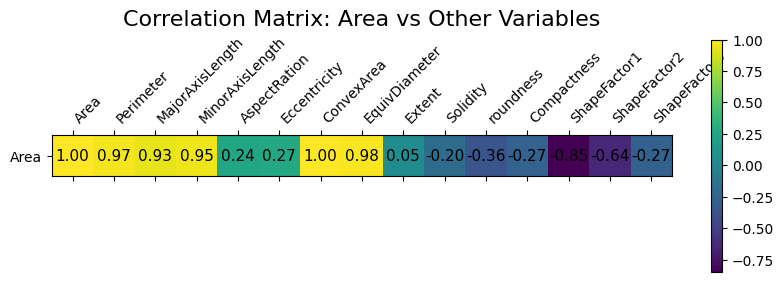

In [9]:
# Create correlation matrix for Area against all the other variables
df["Class"] = df["Class"].astype('category')
f = plt.figure(figsize=(10, 3))
mat = df.corr()[['Area']].iloc[:-1].T
plt.matshow(mat, fignum=f.number)
for (i, j), z in np.ndenumerate(mat):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=11)
plt.xticks(range(mat.shape[1]), mat.columns, fontsize=10, ha="left", rotation=45)
plt.yticks(range(mat.shape[0]), mat.index, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix: Area vs Other Variables', fontsize=16)

### 5.3.2 Validate the model's performance in this setting
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- Feature selection enabled by choosing the 3 features with the highest correlations to Area
- No PCA

K-Fold Cross-Validation Results:
train_R^2: 0.9764374616842847
test_R^2: 0.9762843974993048
RMSE: 4529.758416293777

Performance on the Test Dataset:
R^2: 0.9757746984807172
RMSE: 4410.164759903371


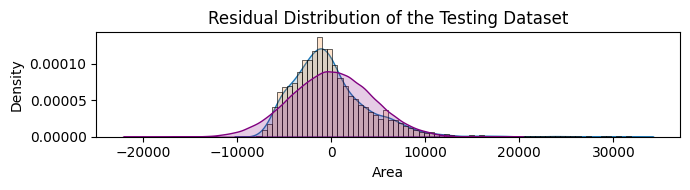

In [10]:
model_validation_regression(base_model=LinearRegression(),
                            cv_splits=5, cv_repeats=1, split_test_size=.4, split_random_state=47,
                            feature_select=['EquivDiameter', 'Perimeter', 'MinorAxisLength'], if_pca=False)

## 5.4 Conclusion
- For the above two implementations of the multilinear regression model, it is obvious that the latter one using feature selection achieved a much better results in terms of both the R^2 and RMSE metrics.
- In terms of the residual distribution of the testing dataset, it is clear that the center of the distribution is closer to 0 for the case using 3 selected features.

# 6 Employ Classification Learners for Class
In this report, the performance of the classification learners investigated will be evaluated based on the metrics of accuracy and log loss during k-fold validation on the training dataset and testing on the testing dataset. The following classification learners will be investigated:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors
- MLP Classifier
- AdaBoost Classifier
- SVM

## 6.1 Function for Model Validation
This function accomplishes the following tasks in one setting:
- Preprocess the dataset according to the parameters selected.
- Split the dataset into training and testing sets
- Employ k-fold validation by further splitting the training set into subtraining and subtesting sets
- Generate evaluation results for metrics: 1) k-fold training accuracy, testing accuracy and log loss; 2) testing dataset accuracy and log loss
- Display the confusion matrices respectively for k-fold testing result and testing dataset result

In [11]:
def model_validation_classification(base_model=LogisticRegression(), model_name='Logistic Regression',
                                    cv_splits=5, cv_repeats=1, split_test_size=.4, split_random_state=47, 
                                    feature_select=['none'], if_smote=True, if_pca=True, n_pca=3):
    df = pd.read_excel(path_to_file)
    df['Class'] = df['Class'].astype('category')
    
    # Remove outliers per class
    df = remove_outliers(df)
    
    X = df.drop(columns=["Class"])
    y = df['Class']
    
    if feature_select != ['none']:
        X = X[feature_select]
    
    # Split the data into training and testing datasets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, 
                                                        random_state=split_random_state)
    
    # Initiate k-fold cross-validation.
    cv = RepeatedKFold(n_splits=cv_splits, random_state=47, n_repeats=cv_repeats)
    splitting = cv.split(X=X_train, y=y_train)
    
    train_accuracies = []
    test_accuracies = []
    confusion_matrices = []
    log_losses = []
    for train_index, test_index in splitting:
        X_subtraining = X_train.iloc[train_index, :]
        X_subtesting = X_train.iloc[test_index, :]
        y_subtraining = y_train.iloc[train_index]
        y_subtesting = y_train.iloc[test_index]

        # Normalize the data.
        scaler_model = StandardScaler()
        scaler_model.fit(np.array(X_subtraining))
        X_subtraining = scaler_model.transform(np.array(X_subtraining))
        X_subtesting = scaler_model.transform(np.array(X_subtesting))

        # Rebalance the subtraining dataset using SMOTE method.
        if if_smote:
            sm = SMOTE(random_state=47, sampling_strategy='minority', k_neighbors=5)
            X_subtraining, y_subtraining = sm.fit_resample(X_subtraining, y_subtraining)

        # Conduct PCA with specified n_components.
        if if_pca:
            # Apply PCA transformation based on the subtraining dataset.
            pca = PCA(n_components=n_pca)
            pca.fit(X_subtraining)
            X_subtraining = pca.transform(X_subtraining)
            X_subtesting = pca.transform(X_subtesting)

        # Train model based on the subtraining dataset.
        base_model.fit(X=X_subtraining, y=y_subtraining)
        
        # Model validation on the substesting dataset.
        y_pred = base_model.predict(X_subtesting)
        y_pred_proba = base_model.predict_proba(X_subtesting)
        
        train_accuracy = base_model.score(X=X_subtraining, y=y_subtraining)
        test_accuracy = base_model.score(X=X_subtesting, y=y_subtesting)
        test_log_loss = log_loss(y_true=y_subtesting, y_pred=y_pred_proba)
        test_confusion_matrix = confusion_matrix(y_true=y_subtesting, y_pred=y_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        log_losses.append(test_log_loss)
        confusion_matrices.append(test_confusion_matrix)

        ave_train_accuracy = np.mean(train_accuracies)
        ave_test_accuracy = np.mean(test_accuracies)  
        ave_log_loss = np.mean(log_losses)
        ave_test_confusion_matrix = np.sum(confusion_matrices, axis=0)/len(confusion_matrices)
        
    # Evaluate on the testing dataset. 
    # Get the preprocessed data in the same way as defined above
    X_train, X_test, y_train, y_test = get_preprocessed_data('classification', feature_select, if_smote, if_pca, n_pca)
    base_model.fit(X=X_train, y=y_train)
    y_pred = base_model.predict(X_test)
    y_pred_proba = base_model.predict_proba(X_test)
    
    test_accuracy = base_model.score(X=X_test, y=y_test)
    model_log_loss = log_loss(y_true=y_test, y_pred=y_pred_proba)
    test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    df_metrics.iloc[df_metrics.index[df_metrics['Model'] == model_name], 1:] = [ave_train_accuracy, ave_test_accuracy, ave_log_loss, test_accuracy, model_log_loss]
    # Print evaluation results
    print(f"""K-Fold Cross-Validation Results:\ntrain_accuracy: {ave_train_accuracy}\ntest_accuracy: {ave_test_accuracy}\nlog_loss: {ave_log_loss}""") 
    
    print(f"""\nPerformance on the Testing Dataset:\ntest_accuracy: {test_accuracy}\nlog_loss: {model_log_loss}""")
    # Print confusion matrices
    fig, axes = plt.subplots(1, 2)
    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.autolayout"] = True
    ConfusionMatrixDisplay(ave_test_confusion_matrix).plot(ax=axes[0])
    axes[0].set_title('K-Fold Average Test Confusion Matrix')
    ConfusionMatrixDisplay(test_confusion_matrix).plot(ax=axes[1])
    axes[1].set_title('Testing Dataset Confusion Matrix')
    plt.show()

## 6.2 Set up Evaluation Metrics Table for Learners

In [12]:
# Create a dataframe for the evaluation metrics
df_metrics = pd.DataFrame(columns=['Model', 'kfold train acc', 'kfold test acc', 'kfold log loss',
                                  'testing acc', 'testing log loss'])
df_metrics['Model'] = ['Random Forest', 'MLP Classifier', 'SVM', 'Top Learner + PCA', 
                       'Top Learner + PCA + GridSearchCV', 'Top Learner + selected features + GridSearchCV']
df_metrics.head(1)

,Model,kfold train acc,kfold test acc,kfold log loss,testing acc,testing log loss
0,Random Forest,NaN,NaN,NaN,NaN,NaN


## 6.3 Random Forest
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- No PCA and no feature selection

K-Fold Cross-Validation Results:
train_accuracy: 1.0
test_accuracy: 0.9251203454649707
log_loss: 0.25961255512866455

Performance on the Testing Dataset:
test_accuracy: 0.928650852483321
log_loss: 0.2890992343147533


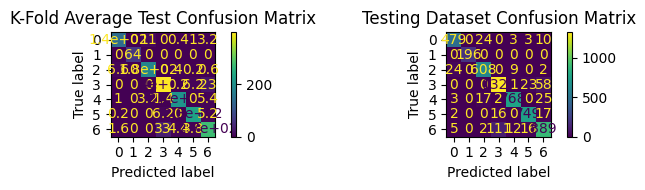

In [13]:
model_validation_classification(base_model=RandomForestClassifier(n_estimators=200, 
                                                                  random_state=47, n_jobs=-1),
                                model_name='Random Forest', cv_splits=5, cv_repeats=1, 
                                split_test_size=.4, split_random_state=47, feature_select=['none'], 
                                if_smote=True, if_pca=False)

## 6.4 MLP Classifier
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- No PCA and no feature selection

K-Fold Cross-Validation Results:
train_accuracy: 0.9577442784710655
test_accuracy: 0.9317931913288658
log_loss: 0.18602121094722088

Performance on the Testing Dataset:
test_accuracy: 0.9360637509266123
log_loss: 0.17714539172084476


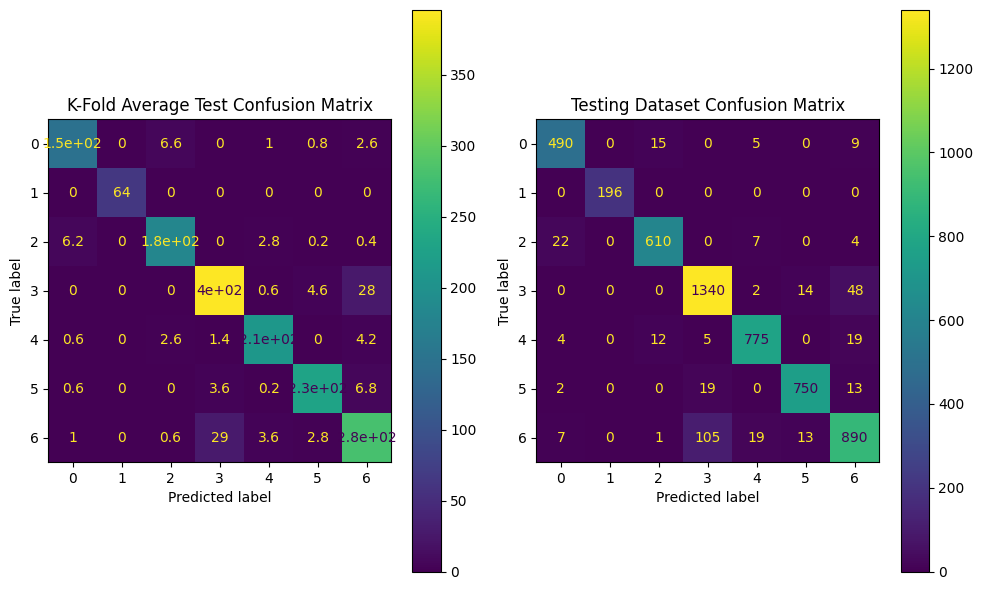

In [14]:
model_validation_classification(base_model=MLPClassifier(random_state=47, activation='relu', 
                                                         max_iter=500, alpha=0.0001),
                                model_name='MLP Classifier', cv_splits=5, cv_repeats=1, 
                                split_test_size=.4, split_random_state=47, feature_select=['none'], 
                                if_smote=True, if_pca=False)

## 6.5 SVM
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- No PCA and no feature selection

K-Fold Cross-Validation Results:
train_accuracy: 0.9526767741502384
test_accuracy: 0.9299394321602785
log_loss: 0.19241726697447642

Performance on the Testing Dataset:
test_accuracy: 0.9369903632320237
log_loss: 0.1883135094430271


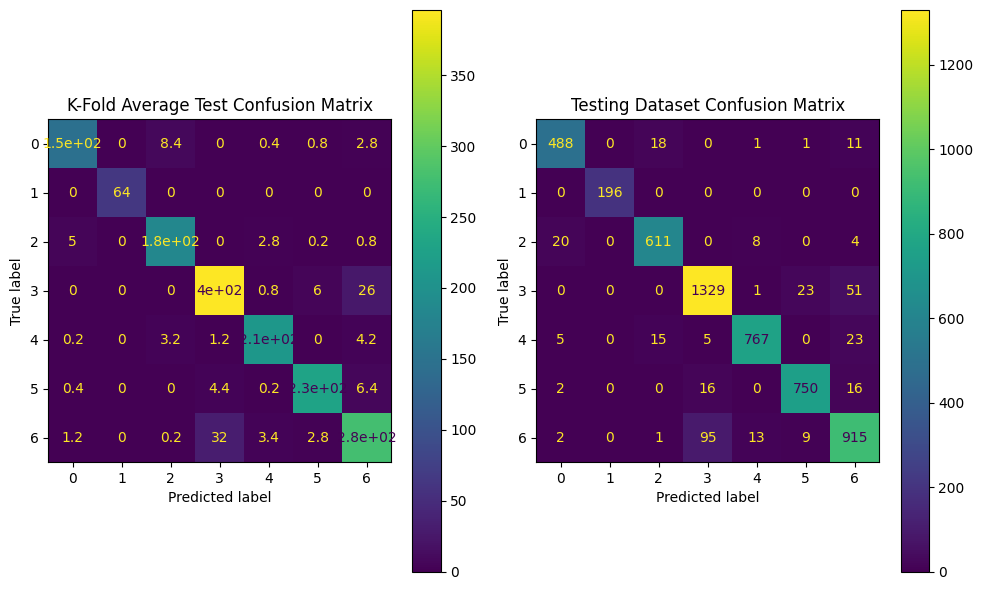

In [15]:
model_validation_classification(base_model=SVC(random_state=47, probability=True, kernel='rbf', gamma=0.1, C=10),
                                model_name='SVM', cv_splits=5, cv_repeats=1, 
                                split_test_size=.4, split_random_state=47, feature_select=['none'], 
                                if_smote=True, if_pca=False)

## 6.6 Other Learners
For the other learners that I have experimented with on my own with inferior results than the above three, I include their code and evaluation metrics result below for comparison. Their data preparation processes are exactly the same as the ones above.

<table>
    <tr>
         <th>Model</th>
         <th>kfold train acc</th>
         <th>kfold test acc</th>
         <th>kfold log loss</th>
         <th>testing acc</th>
         <th>testing log loss</th>
    </tr>
    <tr> 
         <td>K-Nearest Neighbors</td> 
         <td>1.0</td>
         <td>0.91956</td> 
         <td>0.872558</td>
         <td>0.925871</td> 
         <td>0.943496</td>
    </tr>
    <tr> 
         <td>Logistic Regression</td> 
         <td>0.936869</td>
         <td>0.92092</td> 
         <td>0.21122</td>
         <td>0.926242</td> 
         <td>0.204142</td>
    </tr>
    <tr> 
         <td>AdaBoost Classifier</td> 
         <td>0.901406</td>
         <td>0.865934</td> 
         <td>0.42377</td>
         <td>0.866197</td> 
         <td>0.418742</td>
     </tr>
</table>

In [16]:
# model_validation_classification(base_model=LogisticRegression(random_state=47, max_iter=1000,
#                                                                   C=1, n_jobs=-1, 
#                                                                   class_weight='balanced',
#                                                                   multi_class='multinomial'),
#                                 model_name='Logistic Regression', cv_splits=5, cv_repeats=1, 
#                                 split_test_size=.4, split_random_state=47, feature_select=['none'], 
#                                 if_smote=True, if_pca=False)
# model_validation_classification(base_model=KNeighborsClassifier(weights='distance', n_jobs=-1, 
#                                                                 n_neighbors=5),
#                                 model_name='K-Nearest Neighbors', cv_splits=5, cv_repeats=1, 
#                                 split_test_size=.4, split_random_state=47, feature_select=['none'], 
#                                 if_smote=True, if_pca=False)
# model_validation_classification(base_model=AdaBoostClassifier(random_state=47, n_estimators=150, 
#                                                               estimator=DecisionTreeClassifier(max_depth=3)),
#                                 model_name='AdaBoost Classifier', cv_splits=5, cv_repeats=1, 
#                                 split_test_size=.4, split_random_state=47, feature_select=['none'], 
#                                 if_smote=True, if_pca=False)

## 6.7 Conclusion
- From the result summary tables, it is clear that the top learner is the MLP classifier in terms of kfold test acc, kfold log loss, testing acc (slightly lower than that for SVM but negligible) and testing log loss. The confusion matrices support this assessment.
- I did not given so much credit to kfold train acc because the K-Nearest Neighbors and Random Forest are known to do well for that metric and the same performance is not consistent with unseen data.

In [17]:
df_metrics.head(3)

,Model,kfold train acc,kfold test acc,kfold log loss,testing acc,testing log loss
0,Random Forest,1.0,0.92512,0.259613,0.928651,0.289099
1,MLP Classifier,0.957744,0.931793,0.186021,0.936064,0.177145
2,SVM,0.952677,0.929939,0.192417,0.93699,0.188314


# 7 Optimize the Top Learner
## 7.1 Conduct PCA with Optimized n_components
- Use a scatterplot to visualize which n_components achieves the best test accuracy
- Apply PCA with the optimized n_components parameter on data for the top learner

### 7.1.1 Find optimized n_components

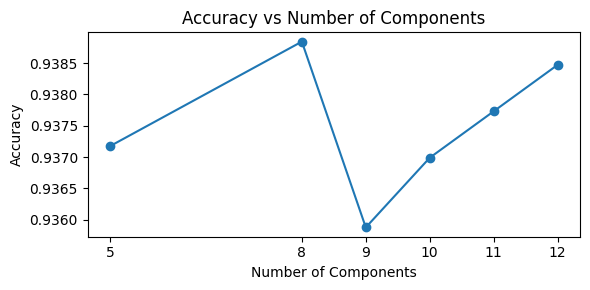

Best Accuracy: 0.9388435878428466
Best Number of Components: 8


In [18]:
# Create the pre-defined number of components list.
component_list = [5,8,9,10,11,12]
accuracies = []
# Iterate through the list.
for num in component_list:
    # Split the data into training and testing datasets.
    X_train, X_test, y_train, y_test = get_preprocessed_data('classification', feature_select=['none'], if_smote=True, if_pca=True, n_pca=num)
    # Train a logisitic regression model.
    model = MLPClassifier(random_state=47, activation='relu', max_iter=500, alpha=0.001)
    model.fit(X_train, y_train)
    # Calculate the accuracy of the model.
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_true=y_test, y_pred=y_pred))
# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(component_list, accuracies, '-o')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(component_list)
plt.show()
print('Best Accuracy:', max(accuracies))
best_num_component = component_list[accuracies.index(max(accuracies))]
print('Best Number of Components:', best_num_component)

### 7.1.2 Validate the learner's performance in this setting
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- PCA is enabled with optimized n_components
- No feature selection

K-Fold Cross-Validation Results:
train_accuracy: 0.9583507740979229
test_accuracy: 0.9317932676780902
log_loss: 0.18476965101464832

Performance on the Testing Dataset:
test_accuracy: 0.9388435878428466
log_loss: 0.17562091064022975


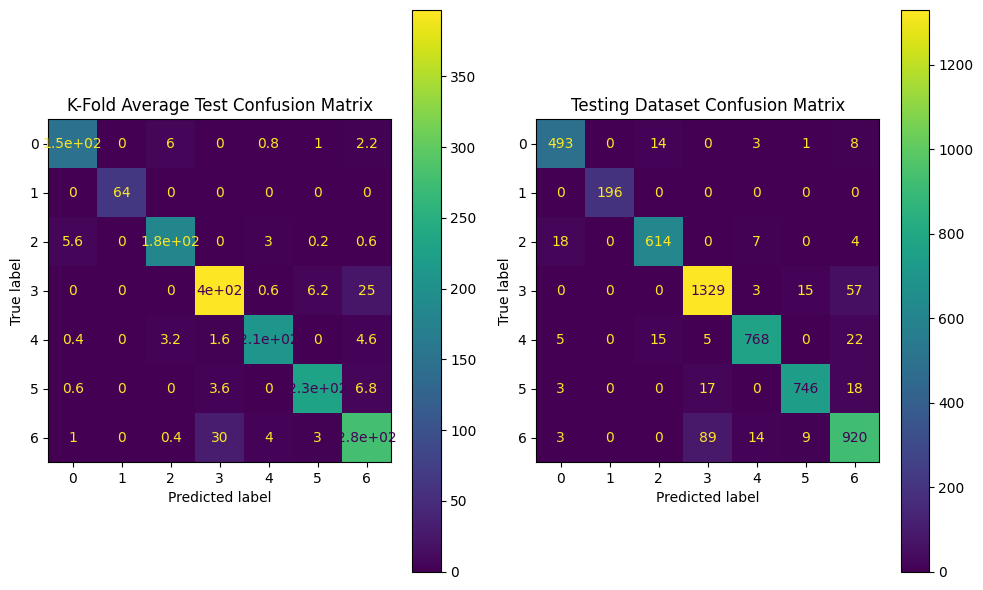

In [19]:
model_validation_classification(base_model=MLPClassifier(random_state=47, activation='relu', 
                                                         max_iter=500, alpha=0.001),
                                model_name='Top Learner + PCA', cv_splits=5, cv_repeats=1, 
                                split_test_size=.4, split_random_state=47, feature_select=['none'], 
                                if_smote=True, if_pca=True, n_pca=best_num_component)

## 7.2 Top Learner + PCA + GridSearchCV
- GridSearchCV performs an exhaustive search over a defined parameter grid. It evaluates all possible combinations of hyperparameters by creating a grid of values for each hyperparameter, and then fits the model with each set of hyperparameters to find the best combination. 
- The disadvantage of this approach is that it can be computationally expensive and time-consuming, especially when there are many hyperparameters and a large number of possible values for each hyperparameter.

### 7.2.1 Use GridSearchCV to find the best parameters and learner
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- PCA is enabled with optimized n_components
- No feature selection
- Model parameters are optimized using GridSearchCV

To save time for running, I conducted some of the ablation experiments on my own and discovered the following perferred parameters:
- For all the experiments with other parameters altered, 'relu' and 'adam' are always the best parameters for activation and solver respectively, so I stop looping through the other values for these two parameters.
- The parameters used in the below param_grid are the ones that showed significant impact on the evaluation metrics based on the outcomes of my prior experiments.

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = get_preprocessed_data('classification', feature_select=['none'], if_smote=True, if_pca=True, n_pca=best_num_component)

# Define the parameter grid to search over
param_grid = {'hidden_layer_sizes': [(20,20,20), (50, 50), (110,), (120,), (130,)],
               'activation': ['relu'],
               'solver': ['adam'],
               'alpha': [0.0001, 0.001, 0.01, 0.1, 1]
             }

# Create a MLPClassifier instance
mlp = MLPClassifier(random_state=47, max_iter=500)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the accuracy on the test set
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))
print("Test set accuracy: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (130,), 'solver': 'adam'}
Test set accuracy: 0.94


### 7.2.2 Validate the learner's performance in this setting

K-Fold Cross-Validation Results:
train_accuracy: 0.957339631152152
test_accuracy: 0.9337700254471966
log_loss: 0.17735861412088125

Performance on the Testing Dataset:
test_accuracy: 0.940511489992587
log_loss: 0.17386196935837495


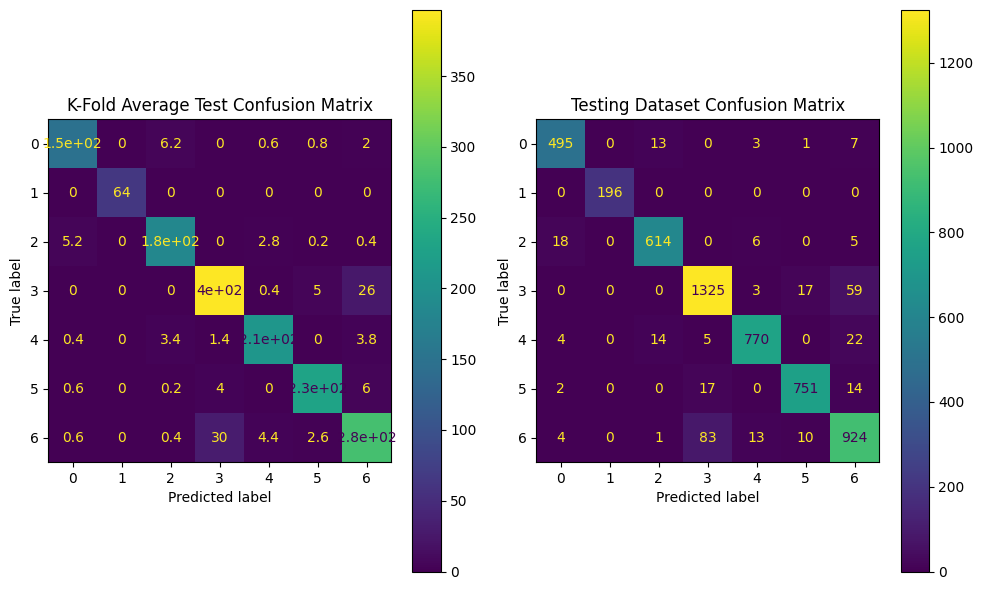

In [21]:
model_validation_classification(base_model=best_model, model_name='Top Learner + PCA + GridSearchCV', 
                                cv_splits=5, cv_repeats=1, split_test_size=.4, split_random_state=47, 
                                feature_select=['none'], if_smote=True, if_pca=True, n_pca=best_num_component)

## 7.3 Top Learner + Selected Features + GridSearchCV
### 7.3.1 Find the most relevant features
I select the top 5 features based on the corrlation martix of class against all other variables. To make correlation analysis possible for Class, I first use the LabelEncoder technique to transfer the categorical variable into numeric labels. The following features have the highest correlations:
1. Perimeter
2. ConvexArea
3. EquivDiameter
4. Area
5. MajorAxisLength

Text(0.5, 1.0, 'Correlation Matrix: Class vs Other Variables')

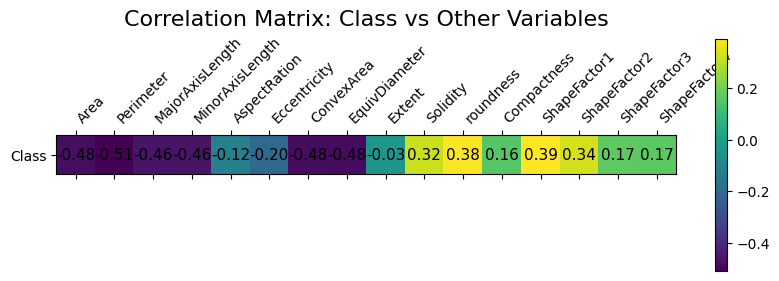

In [22]:
df_tmp = df.copy()
# Instantiate LabelEncoder
label_encoder = LabelEncoder()
# Fit the encoder to the Class categorical column and transform it
df_tmp['Class'] = label_encoder.fit_transform(df_tmp['Class'])
f = plt.figure(figsize=(10, 3))
mat = df_tmp.corr()[['Class']].iloc[:-1].T
plt.matshow(mat, fignum=f.number)
for (i, j), z in np.ndenumerate(mat):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=11)
plt.xticks(range(mat.shape[1]), mat.columns, fontsize=10, ha="left", rotation=45)
plt.yticks(range(mat.shape[0]), mat.index, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix: Class vs Other Variables', fontsize=16)

### 7.3.2 Use GridSearchCV to find the best parameters and learner
Data preparation summary:
- Data is normalized with outliers based on IQR removed
- SMOTE used to rebalance the dataset based on the frequency distribution of Class
- No PCA
- Feature selection is enable with the top 5 correlated features
- Model parameters are optimized using GridSearchCV

In [23]:
# Define the selected features
features = ['Perimeter', 'Area', 'MajorAxisLength', 'ConvexArea', 'EquivDiameter']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = get_preprocessed_data('classification', feature_select=features, if_smote=True, if_pca=False, n_pca=best_num_component)

# Define the parameter grid to search over
param_grid = {'hidden_layer_sizes': [(20,20,20), (50, 50), (110,), (120,), (130,)],
               'activation': ['relu'],
               'solver': ['adam'],
               'alpha': [0.0001, 0.001, 0.01, 0.1, 1]
             }

# Create a MLPClassifier instance
mlp = MLPClassifier(random_state=47, max_iter=500)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the accuracy on the test set
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))
print("Test set accuracy: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (120,), 'solver': 'adam'}
Test set accuracy: 0.92


### 7.3.3 Validate the learner's performance in this setting

K-Fold Cross-Validation Results:
train_accuracy: 0.9306393823141249
test_accuracy: 0.9141227741337989
log_loss: 0.22391869869073622

Performance on the Testing Dataset:
test_accuracy: 0.9190140845070423
log_loss: 0.21983662936552617


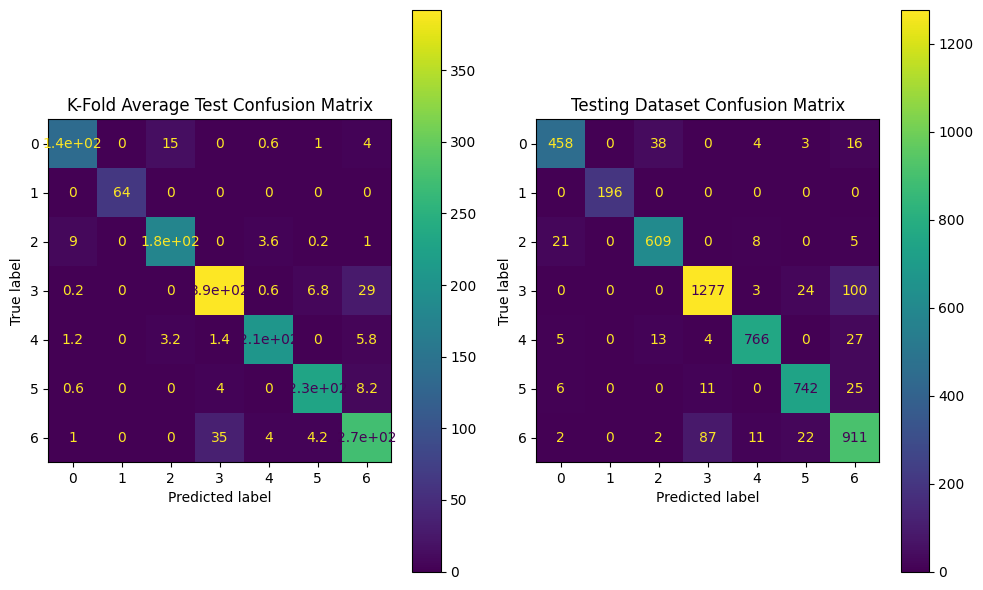

In [24]:
model_validation_classification(base_model=best_model,
                                model_name='Top Learner + selected features + GridSearchCV', cv_splits=5, cv_repeats=1, 
                                split_test_size=.4, split_random_state=47, feature_select=features, 
                                if_smote=True, if_pca=False, n_pca=best_num_component)

## 7.4 Conclusion

Based on the overall result table below, we can reach the following conclusions for the approaches to optimize the top learner:
- Top learner + PCA is proven effective with a small improvements over kfold train acc, kfold log loss, testing acc, and testing log loss.
- Top learner + PCA + GridSearchCV further improves the evaluation results over kfold test acc, kfold log loss, testing acc and testing log loss.
- Top learner + selected features + GridSearchCV does not yield better results as maybe too much information is lost due to the feature exclusion and the selected features' correlations to Class are not high enough in the first place.

In [25]:
df_metrics

,Model,kfold train acc,kfold test acc,kfold log loss,testing acc,testing log loss
0,Random Forest,1.0,0.92512,0.259613,0.928651,0.289099
1,MLP Classifier,0.957744,0.931793,0.186021,0.936064,0.177145
2,SVM,0.952677,0.929939,0.192417,0.93699,0.188314
3,Top Learner + PCA,0.958351,0.931793,0.18477,0.938844,0.175621
4,Top Learner + PCA + GridSearchCV,0.95734,0.93377,0.177359,0.940511,0.173862
5,Top Learner + selected features + GridSearchCV,0.930639,0.914123,0.223919,0.919014,0.219837
